# LSTM Model  
**Predicting Droughts Using Weather & Soil Data in the US**



This notebook is designed to run on Google Colab. It requires at least 25 GB of system RAM and 1.5 GB of GPU RAM, so a T4 GPU with high-RAM runtime is recommended.

You do not need to manually install any datasets. The datasets are downloaded through kaggle when you run the cell code.

If you want to perform full training, simply run all the cells in this notebook.

The instruction for loading the model parameters can be found at the last cell of this notebook.

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data preprocessing

In [ ]:
path = kagglehub.dataset_download("cdminix/us-drought-meteorological-data")

# Load data
soil_df = pd.read_csv(os.path.join(path, "soil_data.csv"))
train_df = pd.read_csv(os.path.join(path, "train_timeseries/train_timeseries.csv"))
val_df = pd.read_csv(os.path.join(path, "validation_timeseries/validation_timeseries.csv"))
test_df = pd.read_csv(os.path.join(path, "test_timeseries/test_timeseries.csv"))

# Define feature lists
weather_features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN',
                    'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE',
                    'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']
soil_features = ['lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5',
                 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW',
                 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND',
                 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5',
                 'SQ6', 'SQ7']

100%|██████████| 901M/901M [00:06<00:00, 148MB/s]

Extracting files...


In [ ]:
# Merge soil data and add seasonal features
for df in [train_df, val_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(['fips', 'date'], inplace=True)
    day_of_year = df['date'].dt.dayofyear
    df['season_sin'] = np.sin(2 * np.pi * (day_of_year - 1) / 365)
    df['season_cos'] = np.cos(2 * np.pi * (day_of_year - 1) / 365)
train_df = train_df.merge(soil_df, on='fips', how='left')
val_df = val_df.merge(soil_df, on='fips', how='left')
test_df = test_df.merge(soil_df, on='fips', how='left')

In [ ]:
#Normalization with feature scaling
train_features = train_df[weather_features + soil_features].values
feature_mean = np.nanmean(train_features, axis=0)
feature_std = np.nanstd(train_features, axis=0)
feature_std = np.where(feature_std == 0, 1.0, feature_std)
for df in [train_df, val_df, test_df]:
    df[weather_features + soil_features] = (
        df[weather_features + soil_features].values - feature_mean
    ) / feature_std

dynamic_features = weather_features + ['season_sin', 'season_cos']
static_features = soil_features
target = 'score'

In [ ]:
#to prepare the input sequence to the model
#custom pytorch dataset for time series drought prediction
class DroughtDataset(Dataset):
    def __init__(self, df, dynamic_features, static_features, target, seq_length=30):
        #Store feature and target column names, and sequence length
        self.dynamic_features = dynamic_features
        self.static_features = static_features
        self.target = target
        self.seq_length = seq_length
        self.data = {}      #Dictionary to store processed data for each region (fips)
        self.indices = []   #List of (fips, start_index) for generating sequences
        df = df.sort_values(['fips', 'date']).copy()
        for fips, fips_df in df.groupby('fips'):
            #Extract dynamic (time-varying) features as a NumPy array
            X_dynamic = fips_df[dynamic_features].values.astype(np.float32)
            #Extract static (constant per region) features from the first row
            X_static = fips_df[static_features].iloc[0].values.astype(np.float32)
            #Extract the target values
            y = fips_df[target].values.astype(np.float32)
            self.data[fips] = {'X_dynamic': X_dynamic, 'X_static': X_static, 'y': y}
            #Create indices for valid input-output sequences
            for i in range(len(fips_df) - seq_length):
                #Only use samples where the target value after the sequence is not NaN
                if not np.isnan(y[i + seq_length]):
                    self.indices.append((fips, i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        fips, start_idx = self.indices[idx]
        X_dynamic = self.data[fips]['X_dynamic'][start_idx:start_idx + self.seq_length]
        X_static = self.data[fips]['X_static']
        y = self.data[fips]['y'][start_idx + self.seq_length]
        return (torch.from_numpy(X_dynamic), torch.from_numpy(X_static), torch.tensor(y, dtype=torch.float32))

# Model LSTM

In [ ]:
class DroughtLSTMHybrid(nn.Module):
    def __init__(self, dynamic_input_size, static_input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(DroughtLSTMHybrid, self).__init__()
        self.lstm = nn.LSTM(dynamic_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        #Linear layer to process static features 
        self.fc_static = nn.Linear(static_input_size, hidden_size)
        #Final linear layer to map the combined features to the output
        self.fc_final = nn.Linear(hidden_size * 2, output_size)
        #Activation and dropout for non-linearity and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_dynamic, x_static):
        #Pass dynamic features through LSTM and take output from the last time step
        lstm_out, _ = self.lstm(x_dynamic)
        lstm_out = lstm_out[:, -1, :]        #shape: (batch_size, hidden_size)
        #Pass static features through a fully connected layer with ReLU
        static_out = self.relu(self.fc_static(x_static))         #shape: (batch_size, hidden_size)
        #Concatenate LSTM output and static outputs
        combined = torch.cat((lstm_out, static_out), dim=1)
        #Apply dropout before final prediction
        combined = self.dropout(combined)
        #Final prediction layer
        out = self.fc_final(combined)       #shape: (batch_size,)
        return out.squeeze(-1)

# Train function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience=3, scheduler=None):
    train_losses, val_losses, val_maes = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        #Training loop
        model.train()
        train_loss, train_mae, train_samples = 0.0, 0.0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X_dynamic, X_static, y_batch in train_bar:
            X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_dynamic, X_static)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_dynamic.size(0)
            mae = torch.mean(torch.abs(outputs - y_batch))
            train_mae += mae.item() * X_dynamic.size(0)
            train_samples += X_dynamic.size(0)
            train_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        train_loss /= train_samples
        train_mae /= train_samples
        train_losses.append(train_loss)

        #Validation loop
        model.eval()
        val_loss, val_mae, val_samples = 0.0, 0.0, 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X_dynamic, X_static, y_batch in val_bar:
                X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
                outputs = model(X_dynamic, X_static)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_dynamic.size(0)
                mae = torch.mean(torch.abs(outputs - y_batch))
                val_mae += mae.item() * X_dynamic.size(0)
                val_samples += X_dynamic.size(0)
                val_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        val_loss /= val_samples
        val_mae /= val_samples
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        #Checkpointing and Early Stopping
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{save_path}_epoch{epoch+1}.pt")
        print(f"Checkpoint saved at {save_path}_epoch{epoch+1}.pt")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(checkpoint, save_path)
            print(f"Best model updated at {save_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        #Step the scheduler with the validation loss
        if scheduler:
            scheduler.step(val_loss)

    #Plot losses and MAE
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(val_maes)+1), val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses, val_maes

In [ ]:
#Hyperparameters
seq_length = 180
batch_size = 2048
num_epochs = 10
save_path = 'best_model7.pt'
patience = 3  # For early stopping
dropout = 0.2

In [ ]:
train_dataset = DroughtDataset(train_df, dynamic_features, static_features, target, seq_length)
val_dataset = DroughtDataset(val_df, dynamic_features, static_features, target, seq_length)
test_dataset = DroughtDataset(test_df, dynamic_features, static_features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Epoch 1/10 [Val]: 100%|██████████| 119/119 [00:04<00:00, 23.92it/s, Loss=1.04, MAE=0.876]


Epoch 1/10, Train Loss: 0.7351, Train MAE: 0.5870, Val Loss: 0.4483, Val MAE: 0.4296
Checkpoint saved at best_model7.pt_epoch1.pt
Best model updated at best_model7.pt


Epoch 2/10 [Val]: 100%|██████████| 119/119 [00:05<00:00, 23.58it/s, Loss=1.75, MAE=1.11]


Epoch 2/10, Train Loss: 0.4950, Train MAE: 0.4710, Val Loss: 0.4788, Val MAE: 0.4329
Checkpoint saved at best_model7.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 119/119 [00:05<00:00, 20.97it/s, Loss=1.25, MAE=0.918]


Epoch 3/10, Train Loss: 0.4096, Train MAE: 0.4245, Val Loss: 0.4769, Val MAE: 0.4177
Checkpoint saved at best_model7.pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 119/119 [00:05<00:00, 23.66it/s, Loss=1.64, MAE=1.02]


Epoch 4/10, Train Loss: 0.3519, Train MAE: 0.3912, Val Loss: 0.5172, Val MAE: 0.4331
Checkpoint saved at best_model7.pt_epoch4.pt
Early stopping triggered after 4 epochs


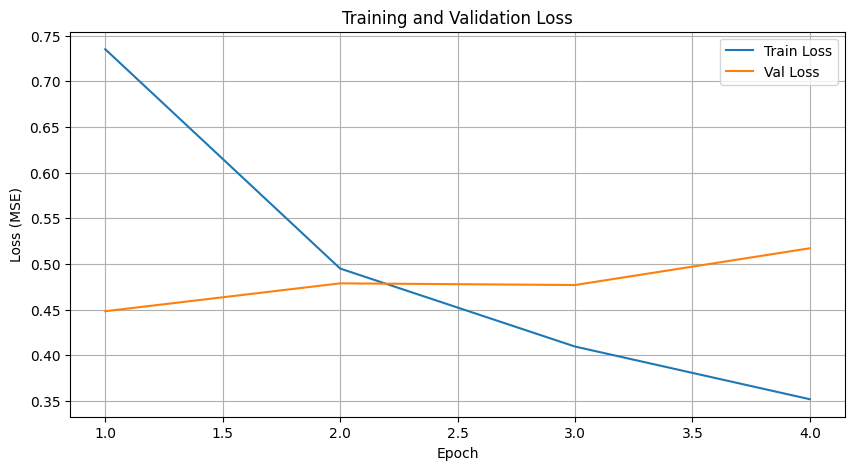

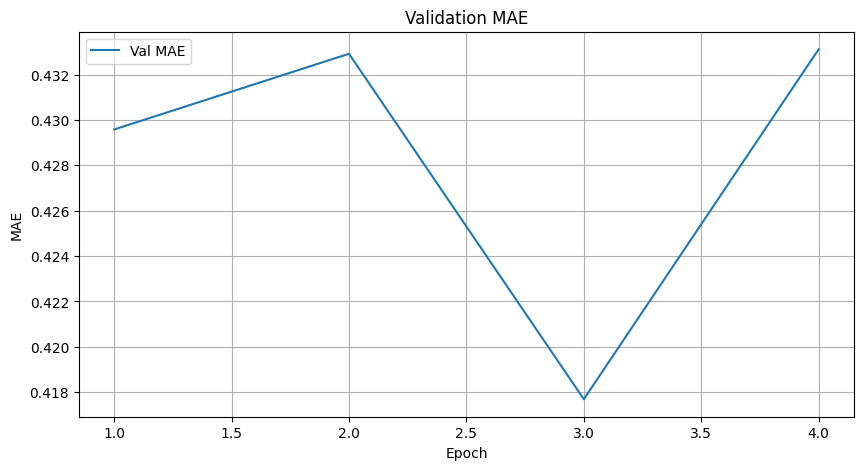

Test Evaluation: 100%|██████████| 120/120 [00:05<00:00, 23.77it/s]


Test Loss: 0.4965, Test MAE: 0.4199


In [ ]:
# if you intend to load model parameter instead, you can skip this cell
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DroughtLSTMHybrid(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=64,
    num_layers=2,
    dropout=dropout
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Train the model with the scheduler
model, train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience, scheduler
)

# Evaluate on the test set
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))

run this cell below if you want to load the model parameter

In [ ]:
# Run this if you intend to just load the model parameter
#Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DroughtLSTMHybrid(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=64,
    num_layers=2,
    dropout=dropout
).to(device)

checkpoint_path = save_path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))